# Project 5: recurrent neural networks, protein fold classification

In this project, we will continue our exploration of deep learning methods in computational biology. In the first part of this assignment, you will implement a long short-term memory (LSTM) neural network in PyTorch to compute the XOR of variable-length binary sequences. In the second part, you will use the same building blocks from part one to design a neural network that can classify small protein sequences into one of many hundred folds.

**Deep Learning Resources**

If you would like more resources on deep learning to complete this assignment, we recommend checking out the following resources:
- the Deep Learning textbook: https://www.deeplearningbook.org/
- notes from CS182 (Berkeley's deep learning course): https://cs182sp21.github.io/

**PyTorch**

By now, you should all be familiar with PyTorch. Still, you will likely need to reference the documentation on [their website](https://pytorch.org/docs/stable/index.html). We will be using PyTorch version 1.7, which comes pre-installed with Colab.

**Colab**

As with the previous assignment, you will Google Colab. To get started, make a copy of this assignment by clicking ``File->Save a copy in drive``. You will need to be logged into a Google account, such as your @berkeley.edu account.

To access a GPU, go to ``Edit->Notebook settings`` and select ``GPU`` in the ``Hardware accelerator`` dropdown. As soon as you run a code shill (by pressing ``Shift+Enter``), you will be connected to a cloud instance with a GPU. 

In [1]:
# Standard library imports
from collections import defaultdict
from copy import deepcopy
import json
import math
import os
import pickle
import random

# Third party imports
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.notebook

Before proceeding, let's verify that we are connected to a GPU runtime and that ``torch`` can detect the GPU. We'll define a variable ``device`` here to use throughout the code, so that we can easily change to run on CPU for debugging.

In [2]:
assert torch.cuda.is_available()
device = torch.device("cuda") # change the argument to "cpu" in order to use the CPU for debugging purposes instead
print("Using device: {}".format(device))

Using device: cuda


## Part 1: XOR LSTM (30 pt)

In this part, you will implement an LSTM to calculate the XOR (exclusive or) of a variable-length binary sequence. What does an XOR on a sequence of length > 2 mean? While some scholars disagree, for our purposes, we will treat it as computing the odd parity function:
$$XOR(x_{1}, \ldots, x_{n}) = \left(\sum_{i = 1}^{n} x_{i}\right) \% \, 2$$


The following are two examples of what the LSTM is supposed to compute
- $XOR([0, 1, 0, 1, 0, 1]) = 3 \% 2 = 1$
- $XOR([1, 1]) = 2 \% 2 = 0$

As with the last assignment, before defining the model architecture, we need to implement a ``torch.utils.data.Dataset`` class that returns the data used to train the model. Below, we provide a partial implementation of this class that--at each index--returns a random sequence with length between 1 and 25 and its corresponding XOR. 

However, as you will notice, the static ``collate`` function is left for you to implement. Recall from the previous assignment that the ``__getitem__`` function of a ``Dataset`` class returns information about a single example. Then, the ``DataLoader`` class would automatically batch examples together. This automatic batching only works if all items returned from the ``__getitem__`` function have the same length. However, in this case, our sequences are of different lengths. Therefore, we have to define a ``collate`` function that manually batches the data. In the ``collate`` function---given a list of tuples where each tuple consists of a sequence tensor and a parity tensor from ``__getitem__``---we must pad each sequence to the same length and then return three tensors: one for the batched sequences, one for the batched labels, and one for the batched pre-padded sequence lengths.

(10 pt) Implement the ``collate`` function below.

In [89]:
PAD_ID = -1

class XORDataset(torch.utils.data.Dataset):
  def __init__(self, num_examples=5_000, max_length=25):
    self.num_examples = num_examples
    self.max_length = max_length
  
  def __len__(self):
    return self.num_examples
  
  def __getitem__(self, index):
    length = np.random.randint(1, high=self.max_length + 1)
    seq = np.random.randint(2, size=(length))
    parity = np.sum(seq) % 2
    return torch.from_numpy(seq), torch.tensor(parity)

  @staticmethod
  def collate(batch):
    """
    Pads sequences of variable length and batches data together.

    Padding should be performed using nn.utils.rnn.pad_sequence with batch_first=False and
    padding_value=PAD_ID.

    Params:
      batch (list) - list of tuples of length B (B = batch_size) where each tuple consists of
                     an unpadded sequence tensor and a parity tensor from __getitem__
    Returns:
      seq_batch (tensor.int64) - batched and padded sequences of size (max_sequence_length, B)
      parity_batch (tensor.int64) - batched labels of size (B)
      seq_lengths_batch (tensor.int64) - batched pre-padded sequence lengths of size (B)
    """
    seq_list = [seq for (seq, _) in batch]
    parity_list = [parity for (_, parity) in batch]
    
    seq_lengths_batch = torch.tensor([len(seq) for seq in seq_list], dtype=torch.int64)
    
    #padding with -1
    seq_batch = nn.utils.rnn.pad_sequence(seq_list, batch_first=False, padding_value=PAD_ID)

    parity_batch = torch.tensor(parity_list, dtype=torch.int64)

    return seq_batch, parity_batch, seq_lengths_batch


If you have implemented the ``collate`` function correctly, the following code block should execute without error.

In [90]:
sample_xor_dataset = XORDataset()
sample_xor_dataloader = torch.utils.data.DataLoader(sample_xor_dataset, batch_size=64, shuffle=False, collate_fn=XORDataset.collate)

seq_batch, parity_batch, seq_lengths_batch = next(iter(sample_xor_dataloader))

# Check that seq_batch is correct
assert type(seq_batch) == torch.Tensor
assert seq_batch.dtype == torch.int64
assert seq_batch.shape[1] == 64

# Check that parity_batch is correct
assert type(parity_batch) == torch.Tensor
assert parity_batch.dtype == torch.int64
assert parity_batch.shape == torch.Size([64])

# Check that seq_lengths_batch is correct
assert type(seq_lengths_batch) == torch.Tensor
assert seq_lengths_batch.dtype == torch.int64
assert seq_lengths_batch.shape == torch.Size([64])

Using your implementation, we can now construct the dataloaders for the trainining, validation, and testing splits.

In [91]:
train_xor_dataloader = torch.utils.data.DataLoader(
    XORDataset(num_examples=100_000), batch_size=64, shuffle=True, collate_fn=XORDataset.collate)
val_xor_dataloader = torch.utils.data.DataLoader(
    XORDataset(num_examples=1_000), batch_size=64, shuffle=False, collate_fn=XORDataset.collate)
test_xor_dataloader = torch.utils.data.DataLoader(
    XORDataset(num_examples=1_000), batch_size=64, shuffle=False, collate_fn=XORDataset.collate)

(10 pt) Now, we are ready to define the model architecture. Implement an LSTM network by filling in the ``XOR_LSTM class below``. Follow these steps in the ``forward`` pass of your network.
- Convert ``X`` to a ``FloatTensor``
- Expand ``X`` to have a third dimension of size 1.
- Use the ``pack_padded_sequence`` function to pack X in a more computationally-efficient form (see [this post](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch) for details).
- Run the packed sequence through a 2-layer LSTM with ``hidden size=4``. 
- Take ``h_n`` (the last hidden state from all layers) as your output.
- Use a linear layer to project ``h_n`` down to 2 dimensions (corresponding to the 2 possible classes)

In [92]:
class XOR_LSTM(nn.Module):
  def __init__(self):
    super().__init__()

    self.hidden_size = 4
    self.num_layers = 2

    self.lstm = nn.LSTM(input_size=1,
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        batch_first=False)

    self.linear = nn.Linear(self.hidden_size * self.num_layers, 2)

    # The CrossEntropyLoss computes the softmax of the scores first, so you do
    # not need to add a separate softmax layer. We could have used the BCELoss
    # (binary cross entropy) as well, but this way allows us to reuse boilerplate
    # code for the next section.
    self.loss = torch.nn.CrossEntropyLoss(reduction="mean")

  def forward(self, X, lengths):
    """
    Computes the forward pass of the network.

    Parameters:
      X (tensor): input tensor of size (max_sequence_length, B) where B is the batch size
      lengths (tensor): input tensor of size (B)
    Returns:
      out (tensor): output scores of size (B, 2); these are unnormalized scores
      that have not yet gone through a softmax
    """
    floatX = torch.unsqueeze(X.float(), -1)
    pack = torch.nn.utils.rnn.pack_padded_sequence(floatX, lengths.to('cpu'), batch_first=False, enforce_sorted=False)
    _, (h_n,_) = self.lstm(pack) # (2, B, 4)
    adjusted = torch.flatten(torch.permute(h_n, (1,0,2)), start_dim=1) #(B, 8)
    out = self.linear(adjusted) #(B,2)
    return out

  def compute_loss(self, X, Y_true, lengths):
    """
    Computes the loss of the network on a minibatch.

    Paramters:
      X (tensor): batched sequences of size (max_sequence_length, B) where B is the batch size
      Y_true (tensor): batched labels of size (B)
      lengths (tensor): batched pre-padded sequence lengths of size (B)
    Returns:
      loss (tensor): cross-entropy loss between the network's predictions and the 
                     ground-truth labels (averaged across all samples in the minibatch)
    """

    output = self(X, lengths)
    loss = self.loss(output, Y_true)
    return loss
  
#some test code
xor = XOR_LSTM()
testX = torch.tensor([[1,1],[0,0],[1,0],[1,-1]]) #(maxlen = 4,B = 2)
true_Y =  torch.tensor([1,0])
lengths = torch.tensor([4,3]) #(B = 2)
xor.compute_loss(testX, true_Y, lengths)

tensor(0.6781, grad_fn=<NllLossBackward0>)

Like last time, we have provided code to both train and evaluate the model. You do not need to modify these functions, but we recommend reading through the code, so that you understand the full workflow.

In [93]:
def train(model, train_dataloader, val_dataloader, num_epochs, lr, weight_decay, model_file):
  """
  Train the model and save its best checkpoint.

  Model performance across epochs is evaluated on the validation set. The best
  checkpoint obtained during training will be stored and disk and loaded back
  into the model at the end of training. This process is known as "early stopping."

  Parameters:
    model (nn.Module): model class
    train_dataloader (torch.utils.data.DataLoader): data loader for the training set
    val_dataloader (torch.utils.data.DataLoader): data loader for the validation set
    num_epochs (int): number of epochs the model is trained for
    lr (float): learning rate
    weight_decay (float): hyperparameter controlling L2 regularization penalty 
    model_file (str): path where model will be saved
  """
  # Create the ADAM optimizer (a variant of SGD) that will be used to train the model
  optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=weight_decay
  )

  # Create the scheduler that will vary the learning rate
  scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader),
    pct_start=0.02  # warm up for 2% of the total training time
  )

  model = model.to(device)

  best_val_accuracy = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(train_dataloader, desc="epoch {}".format(epoch + 1),
                            unit="batch", total=len(train_dataloader)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, (X_batch, Y_batch, lengths_batch) in enumerate(batch_iterator, start=1):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        lengths_batch = lengths_batch.to(device)

        optimizer.zero_grad() # zero out all old gradients
        loss = model.compute_loss(X_batch, Y_batch, lengths_batch)
        total_loss += loss.item()
        loss.backward() # compute gradients
        optimizer.step() # backpropagate
        scheduler.step()
      
      val_accuracy = evaluate(model, val_dataloader)
      batch_iterator.set_postfix(mean_loss=total_loss / i, val_accuracy=val_accuracy)

      if val_accuracy > best_val_accuracy:
        print("Obtained a new best validation accuracy of {:.3f}, saving model checkpoint to {}".
              format(val_accuracy, model_file))
        torch.save(model.state_dict(), model_file)
        best_val_accuracy = val_accuracy
    
  model.load_state_dict(torch.load(model_file))

def evaluate(model, dataloader, predictions_fname=None):
  model = model.to(device)

  if predictions_fname is not None:
    predictions_file = open(predictions_fname, 'w')

  correct, total = 0, 0
  with torch.no_grad():
    for (X_batch, Y_batch, lengths_batch) in dataloader:
      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)
      lengths_batch = lengths_batch.to(device)

      Y_batch_pred = model(X_batch, lengths_batch).argmax(-1)
      correct += (Y_batch_pred == Y_batch).sum().item()
      total += Y_batch.shape[0]

      if predictions_fname is not None:
        predicted_labels = Y_batch_pred.cpu().tolist()
        true_labels = Y_batch.cpu().tolist()
        for (pred, truth) in zip(predicted_labels, true_labels):
          predictions_file.write("{} {}\n".format(pred, truth))
  
  return correct / total

(10 pt) You can now train your LSTM. If you have implemented the model correctly, you should achieve an accuracy greater than 0.99 on the validation set using the provided hyperparameters.

In [94]:
xor_lstm = XOR_LSTM()
train(xor_lstm, train_xor_dataloader, val_xor_dataloader, 10, 1e-3, 0.0, "xor_lstm.pt")

training:   0%|          | 0/10 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/1563 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.529, saving model checkpoint to xor_lstm.pt


epoch 2:   0%|          | 0/1563 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.533, saving model checkpoint to xor_lstm.pt


epoch 3:   0%|          | 0/1563 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.565, saving model checkpoint to xor_lstm.pt


epoch 4:   0%|          | 0/1563 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.694, saving model checkpoint to xor_lstm.pt


epoch 5:   0%|          | 0/1563 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 1.000, saving model checkpoint to xor_lstm.pt


epoch 6:   0%|          | 0/1563 [00:00<?, ?batch/s]

epoch 7:   0%|          | 0/1563 [00:00<?, ?batch/s]

epoch 8:   0%|          | 0/1563 [00:00<?, ?batch/s]

epoch 9:   0%|          | 0/1563 [00:00<?, ?batch/s]

epoch 10:   0%|          | 0/1563 [00:00<?, ?batch/s]

In [95]:
test_set_accuracy = evaluate(xor_lstm, test_xor_dataloader, "xor_lstm_test_predictions.txt")
print("Test set accuracy: {}".format(test_set_accuracy))

Test set accuracy: 1.0


## Part 2: Protein fold classification (70 pt)

As discussed in class, a protein's structure can be described at multiple levels. The primary structure lists the sequence of amino acids in a polypeptide chain. The secondary structure refers to specific folded structures that form within a polypeptide due to interactions between atoms of the backbone. A central goal throughout the history of computational biology has been to determine a protein's secondary structure from its primary structure, and in this part of the homework, you will design a neural network to do exactly this.

A large catalogue of mappings between the primary structure and the secondary structure of proteins is found in the Structural Classification of Proteins (SCOP) database. This database organizes **structural domains** (defined as subsequences of proteins that fold independently from the rest) from a huge diversity of organisms into a hierarchical tree--similar to an evolutionary tree. The levels in the SCOP hierarchy are

(1) Class: types of folds (e.g. beta sheets)

(2) Fold: different shapes of domains within a class

...

(7) Domain: a specific domain within a specific protein



Our goal in this problem is use recurrent neural networks, specifically LSTMs, to predict a domain's fold using only its sequence.

(10 pt) An example of a fold witin the SCOP dataset is the [beta-beta-alpha zinc finger](https://scop.berkeley.edu/sunid=57666). Read [this article](https://pdb101.rcsb.org/motm/87) on zinc fingers and then answer the following questions.

1. Why are zinc atoms useful in protein folding?

2. Do you expect mutations in the zinc finger of the protein to influence gene expression? Why?

3. Describe a simple non-neural network based classifier that might be very good at predicting whether a domain is a zinc finger.

**Answer**:
1. Zinc atoms are useful because they significantly reduce the number of amino acids required to form a stable 3D structure of a folded protein. Usually, 100s or 1000s of amino acids are required to fold into a stable, 3D protein structure because a combination of many weak forces is needed (hydrophobic, hydrogen bonds, charge-charge-interactions). With a Zinc atom, only 4 specific amino acids in a row are required to create a stable tetrahedron around the Zinc atom. In addition with a small number (~20) of other amino acids, the stable 3D zinc finger protein is created.
2. Absolutely. Zinc fingers are often found to bind to DNA and RNA to help with transcribing them. They attach to the groves or extend certain amino acids of the DNA or RNA. With a mutation in the zinc finger, it may not bind accurately to the DNA or RNA's genetic information anymore, and, e.g., fail to recognize a base pair which changes the transcription of the DNA or RNA. A transcription change most likely influences gene expression.
3. To predict whether a domain (i.e. a subsequence) is a zinc finger, we would only need to detect the four zinc-finger specifying amino acids in the correct order. Specifically, two cysteins followed by two histidines in the amino acid chain of the primary structure can tell us whether a domain is a zinc finger (CCHH). If we literally only care about predicting whether a domain is a zinc finger (i.e., Yes or No), a simple HMM that looks at 4-amino-acid kmers in the domain might be very good at predicting that.

Below, we provide code to download the SCOP data and read fold information from the FASTA file.

In [3]:
%%bash
wget --quiet https://scop.berkeley.edu/downloads/scopseq-1.75/astral-scopdom-seqres-gd-sel-gs-bib-95-1.75.fa

In [4]:
SCOP_FA_PATH = "astral-scopdom-seqres-gd-sel-gs-bib-95-1.75.fa" # path to SCOP file we just downloaded

def read_scop_data():
  """
  Reads the .fa file and returns a list of (sequence, fold) tuples
  """
  data = []

  fold = None
  seq = ""

  with open(SCOP_FA_PATH, 'r') as f:
    for line in f:
      if line.startswith(">"):
        # if there is old data, we should flush to the list
        if fold is not None and len(seq) > 0:
          data.append((seq, fold))

        # reinitialize fold and seq data
        domain_information = line.split(' ')[1]
        fold = '.'.join(domain_information.split('.')[: 2])
        seq = ""
      else:
        seq += line.strip().upper()
    
    data.append((seq, fold))
  
  return data

As you can see from the below code block, each element in ``scop_data`` list consists of a (amino acid sequence, fold) tuple. 

In [5]:
scop_data = read_scop_data()
assert len(scop_data) == 16712
scop_data[0]

('SLFEQLGGQAAVQAVTAQFYANIQADATVATFFNGIDMPNQTNKTAAFLCAALGGPNAWTGRNLKEVHANMGVSNAQFTTVIGHLRSALTGAGVAAALVEQTVAVAETVRGDVVTV',
 'a.1')

(10 pt) If we tried to train our model on all of the fold data in SCOP, we would not do so well. Instead, we must filter the data in two ways. First, we must remove sequences longer than 256 amino acids, as LSTM models do not perform well on sequences of longer length. Secondly, we must remove folds for which there are less than 10 sequences (after the length-based filtering), as if there are insufficient training examples for that fold, we have little hope of doing well at test time. Implement this in the ``filter_scop_data`` function below.

In [6]:
def filter_scop_data(scop_data):
  """
  Filters the SCOP data such that there are no sequences of > 256 amino acids
  and such that each fold class contains at least 10 sequences.

  Params:
    scop_data (list) - list of (sequence, fold) tuples
  Returns:
    filtered_scop_data (list) - list of filtered (sequence, fold) tuples
  """
  counter = {}
  filtered = []
  filtered_scop_data = []

  for elem in scop_data:
    if len(elem[0]) <= 256:
      filtered.append(elem)
      if elem[1] in counter:
        counter[elem[1]] = counter[elem[1]] + 1
      else:
        counter[elem[1]] = 1

  for elem in filtered:
    if counter[elem[1]] >= 10:
      filtered_scop_data.append(elem)

  return filtered_scop_data

If you have implemented ``filter_scop_data`` correctly, you should be left with 11494 examples out of the original 16712.

In [7]:
filtered_scop_data = filter_scop_data(scop_data)
assert len(filtered_scop_data) == 11494

Currently, our sequences are strings of amino acid characters and our folds are alphanumerical strings. But, machine learning systems expect our data to be numerics, so we have written code to map the raw data to numerical indexes. This mapping is done in alphabetic order for both the amino acids and the folds, such that the amino acid `A` (alanine) is mapped to the index 0 and the amino acid `Z` (gluatimic acid) is mapped to the index 22. 

You may be wondering why we have 23 amino acids, and not the usual 20. That is because SCOP includes three other characters:
- aspartic acid (B)
- glutamic acid (Z)
- any amino acid (X)

In [8]:
def map_scop_data(filtered_scop_data):
  amino_acids_set = set()
  for (seq, _) in filtered_scop_data:
    for char in seq:
      amino_acids_set.add(char)
  amino_acids_map = {amino_acid: i for i, amino_acid in enumerate(sorted(amino_acids_set))}

  folds_set = set([fold for (_, fold) in filtered_scop_data])
  folds_map = {folds: i for i, folds in enumerate(sorted(folds_set))}

  def map_sequence(seq):
    return [amino_acids_map[char] for char in seq]
  
  def map_fold(fold):
    return folds_map[fold]
  
  mapped_scop_data = [(map_sequence(seq), map_fold(fold)) for (seq, fold) in filtered_scop_data]
  return mapped_scop_data

mapped_scop_data = map_scop_data(filtered_scop_data)
print("Example 0, mapped amino acid sequence: {}".format(mapped_scop_data[0][0]))
print("Example 0, mapped fold: {}".format(mapped_scop_data[0][1]))

Example 0, mapped amino acid sequence: [16, 10, 5, 4, 14, 10, 6, 6, 14, 0, 0, 18, 14, 0, 18, 17, 0, 14, 5, 21, 0, 12, 8, 14, 0, 3, 0, 17, 18, 0, 17, 5, 5, 12, 6, 8, 3, 11, 13, 12, 14, 17, 12, 9, 17, 0, 0, 5, 10, 2, 0, 0, 10, 6, 6, 13, 12, 0, 19, 17, 6, 15, 12, 10, 9, 4, 18, 7, 0, 12, 11, 6, 18, 16, 12, 0, 14, 5, 17, 17, 18, 8, 6, 7, 10, 15, 16, 0, 10, 17, 6, 0, 6, 18, 0, 0, 0, 10, 18, 4, 14, 17, 18, 0, 18, 0, 4, 17, 18, 15, 6, 3, 18, 18, 17, 18]
Example 0, mapped fold: 0


We can now shuffle our dataset and split it into training, validation, and testing sets.

In [76]:
train_end = int(0.8 * len(mapped_scop_data))
val_end = int(0.9 * len(mapped_scop_data))

random.shuffle(mapped_scop_data)
train_scop_data = mapped_scop_data[: train_end]
val_scop_data = mapped_scop_data[train_end: val_end]
test_scop_data = mapped_scop_data[val_end: ]

(10 pt) Fill in the SCOPDataset class below. Since these folds are of variable-length, you will have to define a ``collate`` function that pads them and manually batches them together.

In [77]:
NUM_AMINO_ACIDS = 23
NUM_FOLDS = max([fold for _, fold in mapped_scop_data]) + 1 # compute the number of folds in our dataset
PAD_ID = 23 # set the PAD_ID to be 1 more than the last amino acid id

class SCOPDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    #data = list of tuples     
    self.data = data
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])

  @staticmethod
  def collate(batch):
    """
    Pads sequences of variable length and batches data together.

    Padding should be performed using nn.utils.rnn.pad_sequence with batch_first=False and
    padding_value=PAD_ID.

    Params:
      batch (list) - list of tuples of length B (B = batch_size) where each tuple consists of
                     an unpadded sequence tensor and label tensor from __getitem__
    Returns:
      seq_batch (tensor.int64) - batched and padded sequences of size (max_sequence_length, B)
      labels_batch (tensor.int64) - batched labels of size (B)
      seq_lengths_batch (tensor.int64) - batched pre-padded sequence lengths of size (B)
    """
    #Batch is a list of tuples of tensors
    
    seq_list = []
    labels_list = [] 
    seq_lengths_list = []

    for (seq, label) in batch:
      seq_list.append(seq)
      labels_list.append(label)
      seq_lengths_list.append(len(seq))

    seq_batch = nn.utils.rnn.pad_sequence(seq_list, batch_first=False, padding_value=PAD_ID)
    labels_batch = torch.tensor(labels_list, dtype=torch.int64)
    seq_lengths_batch = torch.tensor(seq_lengths_list, dtype=torch.int64)

    return seq_batch, labels_batch, seq_lengths_batch


(5 pt) Write code to check the correctness of the ``collate`` function.

In [78]:
sample_data = mapped_scop_data[0:5]

sample_dataset = SCOPDataset(sample_data)
sample_loader = torch.utils.data.DataLoader(sample_dataset, batch_size=2, shuffle=False, collate_fn=SCOPDataset.collate)

seq_batch, labels_batch, seq_lengths_batch = next(iter(sample_loader))

# Check that seq_batch is correct
assert type(seq_batch) == torch.Tensor
assert seq_batch.dtype == torch.int64
assert seq_batch.shape[1] == 2

# Check that parity_batch is correct
assert type(labels_batch) == torch.Tensor
assert labels_batch.dtype == torch.int64
assert labels_batch.shape == torch.Size([2])

# Check that seq_lengths_batch is correct
assert type(seq_lengths_batch) == torch.Tensor
assert seq_lengths_batch.dtype == torch.int64
assert seq_lengths_batch.shape == torch.Size([2])

Once your checks have passed, you are ready to create the dataloaders.

In [79]:
train_scop_dataloader = torch.utils.data.DataLoader(
    SCOPDataset(train_scop_data), batch_size=64, shuffle=True, collate_fn=SCOPDataset.collate)
val_scop_dataloader = torch.utils.data.DataLoader(
    SCOPDataset(val_scop_data), batch_size=64, shuffle=False, collate_fn=SCOPDataset.collate)
test_scop_dataloader = torch.utils.data.DataLoader(
    SCOPDataset(test_scop_data), batch_size=64, shuffle=False, collate_fn=SCOPDataset.collate)

(10 pt) Implement an LSTM network to predict the fold of a sequence. Your network should follow the below architecture
- an Embedding layer that maps each of the amino acids (+ the extra padding token) to an ``embedding_vector`` of size 32
  - <em> hint </em>: set the ``padding_idx`` when creating the ``Embedding`` layer
- a bidirectional four-layer LSTM with a hidden size of 64
- a Linear layer that maps the final hidden state (``h_n``) to a vector of size ``NUM_FOLDS``


In [80]:
class SCOP_LSTM(nn.Module):
  def __init__(self):
    super().__init__()

    self.hidden_size = 64
    self.num_layers = 4

    self.embedding = nn.Embedding(num_embeddings=NUM_AMINO_ACIDS+1, embedding_dim=32, padding_idx=PAD_ID-1)

    self.lstm = nn.LSTM(input_size=32,
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        batch_first=False,
                        bidirectional=True)

    self.linear = nn.Linear(self.hidden_size * self.num_layers * 2, NUM_FOLDS) #times 2, bidirectional

    self.loss = torch.nn.CrossEntropyLoss(reduction="mean")

  def forward(self, X, lengths):
    """
    Computes the forward pass of the network.

    Parameters:
      X (tensor): input tensor of size (max_sequence_length, B) where B is the batch size
      lengths (tensor): input tensor of size (B)
    Returns:
      out (tensor): output scores of size (B, 2); these are unnormalized scores
      that have not yet gone through a softmax
    """
    embedded = self.embedding(X) # dim: B x max_seq_len x embedding_dim (32)

    pack = torch.nn.utils.rnn.pack_padded_sequence(embedded.float(), lengths.to('cpu'), batch_first=False, enforce_sorted=False)
    _, (h_n,_) = self.lstm(pack) 
    adjusted = torch.flatten(torch.permute(h_n, (1,0,2)), start_dim=1) #(B, 512)
    out = self.linear(adjusted) #(B,2)
    return out

    

  def compute_loss(self, X, Y_true, lengths):
    """
    Computes the loss of the network on a minibatch.

    Paramters:
      X (tensor): batched sequences of size (max_sequence_length, B) where B is the batch size
      Y_true (tensor): batched labels of size (B)
      lengths (tensor): batched pre-padded sequence lengths of size (B)
    Returns:
      loss (tensor): cross-entropy loss between the network's predictions and the 
                     ground-truth labels (averaged across all samples in the minibatch)
    """

    output = self(X, lengths)
    loss = self.loss(output, Y_true)
    return loss

(10 pt) You can now train your fold classification network. If you have implemented the model correctly, you should achieve an accuracy of least 0.420 on the validation set with the given hyperparameters. That accuracy may seem low, but it's quite remarkable that a relatively simple LSTM can pick the correct fold a substantial portion of the time out of 236 possible options.

In [81]:
scop_lstm = SCOP_LSTM()
train(scop_lstm, train_scop_dataloader, val_scop_dataloader, 20, 1e-3, 1e-4, "scop_lstm.pt")

training:   0%|          | 0/20 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.142, saving model checkpoint to scop_lstm.pt


epoch 2:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.191, saving model checkpoint to scop_lstm.pt


epoch 3:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.234, saving model checkpoint to scop_lstm.pt


epoch 4:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.273, saving model checkpoint to scop_lstm.pt


epoch 5:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.288, saving model checkpoint to scop_lstm.pt


epoch 6:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.329, saving model checkpoint to scop_lstm.pt


epoch 7:   0%|          | 0/144 [00:00<?, ?batch/s]

epoch 8:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.352, saving model checkpoint to scop_lstm.pt


epoch 9:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.378, saving model checkpoint to scop_lstm.pt


epoch 10:   0%|          | 0/144 [00:00<?, ?batch/s]

epoch 11:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.393, saving model checkpoint to scop_lstm.pt


epoch 12:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.402, saving model checkpoint to scop_lstm.pt


epoch 13:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.410, saving model checkpoint to scop_lstm.pt


epoch 14:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.413, saving model checkpoint to scop_lstm.pt


epoch 15:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.416, saving model checkpoint to scop_lstm.pt


epoch 16:   0%|          | 0/144 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.424, saving model checkpoint to scop_lstm.pt


epoch 17:   0%|          | 0/144 [00:00<?, ?batch/s]

epoch 18:   0%|          | 0/144 [00:00<?, ?batch/s]

epoch 19:   0%|          | 0/144 [00:00<?, ?batch/s]

epoch 20:   0%|          | 0/144 [00:00<?, ?batch/s]

In [83]:
test_set_accuracy = evaluate(scop_lstm, test_scop_dataloader, "scop_lstm_test_predictions.txt")
print("Test set accuracy: {}".format(test_set_accuracy))

Test set accuracy: 0.42


(10 pt) Create a scatter plot comparing the number of fold examples in the training set to the model's validation accuracy on that fold (exclude folds for which there were no sequences in the validation set). Include the Spearman's rank correlation coefficient between the two quantities. Explain why you think the correlation coefficient is positive.

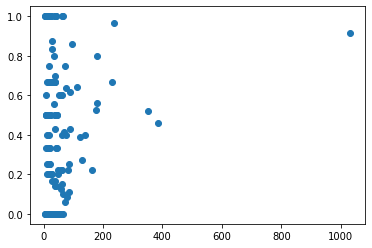

SpearmanrResult(correlation=0.2846897797049679, pvalue=3.217107953986082e-05)


In [85]:
# TODO: create the scatter plot and explain why the correlation coefficient is positive

"""Create X and Y"""
#X np array of 236, containing number of examples for specific folds at list[fold] for the training set.
X = np.zeros(236)
for item in train_scop_data:
  X[item[1]] = X[item[1]] + 1

pred_labels_val = []
true_labels_val = []

#init model
model = scop_lstm.to(device)

with torch.no_grad():
  for (X_batch, Y_batch, lengths_batch) in val_scop_dataloader:
    X_batch = X_batch.to(device)
    lengths_batch = lengths_batch.to(device)

    Y_batch_pred = model(X_batch, lengths_batch).argmax(-1)

    pred_labels_val.extend(Y_batch_pred.tolist())
    true_labels_val.extend(Y_batch.tolist())

#count folds in validation set
true_labels_val = np.array(true_labels_val)
pred_labels_val = np.array(pred_labels_val)

folds_in_val = np.unique(true_labels_val, return_counts=True)
filtered_X = np.take(X, folds_in_val[0])

correct_pred_count = {}

for index, truefold in enumerate(true_labels_val):
  #is this fold in our correct prediction count yet?
  if truefold in correct_pred_count:
    #if predicted label equals actual label
    if pred_labels_val[index] == truefold:
      correct_pred_count[truefold] += 1
  else:
    #if predicted label equals actual label
    if pred_labels_val[index] == truefold:
      correct_pred_count[truefold] = 1
    else:
      correct_pred_count[truefold] = 0

correct_preds_arr = np.array([value for _,value in sorted(correct_pred_count.items())])

Y = correct_preds_arr/folds_in_val[1]

#plot
plt.scatter(filtered_X, Y)
plt.show()

#spearmans's
spearman = spearmanr(filtered_X,Y)
print(spearman)

**EXPLANATION of POSITIVE CORRELATION COEFFICIENT:**

The correlation coefficient is positive between number of training examples and validation accuracy because the LSTM model intuitively will achieve better predictions on the validation set for a fold it 
has seen more examples of in training. It's just better at pattern-matching that way.

(5 pt) Perform a PCA on the embeddings of each amino acid (which are located at ``scop_lstm.embedding.weight``). Using your code, we will plot the first two principle components and color each amino acid according to properties of its side chain.

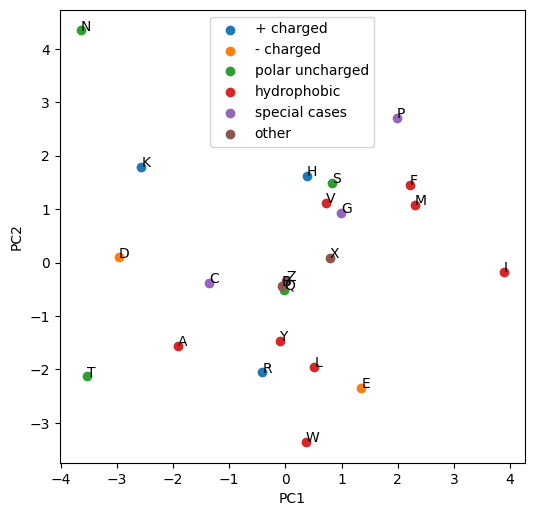

In [88]:
def get_principle_components_of_embeddings(model):
  """
  Returns:
    pcs (np.array): first two principle components for all characters in the
                    vocabulary, includding the padding token; this array should
                    have size (24, 2)
  """
  pca = PCA(n_components=2) 
  pcs = pca.fit_transform(model.embedding.weight.cpu().detach().numpy()) #model weight dims (24,32)

  return pcs #(24,2)

pcs = get_principle_components_of_embeddings(scop_lstm)

# Get the amino acids
amino_acids_set = set()
for (seq, _) in filtered_scop_data:
  for char in seq:
    amino_acids_set.add(char)
sorted_amino_acids = list(sorted(amino_acids_set))

# Label each amino acid according to properties of its side chain
# Side chain properties were found at https://www.technologynetworks.com/applied-sciences/articles/essential-amino-acids-chart-abbreviations-and-structure-324357.
labels = {
    "+ charged": ["R", "H", "K"],
    "- charged": ["D", "E"],
    "polar uncharged": ["S", "T", "N", "Q"],
    "hydrophobic": ["A", "V", "I", "L", "M", "F", "Y", "W"],
    "special cases": ["C", "G", "P"],
    "other": ["B", "X", "Z"]
}

plt.figure(figsize=(6, 6), dpi=100)
for label, amino_acids in labels.items():
  aa_indices = [sorted_amino_acids.index(aa) for aa in amino_acids]
  label_pcs = pcs[aa_indices]
  plt.scatter(label_pcs[:, 0], label_pcs[:, 1], label=label)
for i in range(pcs.shape[0] - 1):
  plt.annotate(sorted_amino_acids[i], (pcs[i][0], pcs[i][1]))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Discuss any patterns in the plot. Why do you think you don't observe tighter clustering by side chain type?

<em> Note </em>: There is no correct answer for the second part of this question. Possible answers range from a discussion of side chain chemistry to critiques of this machine learning setup in learning useful representations. Any thoughtful response will receive full credit.

**Answer**: 
One observable pattern in the plot is the clustering of all hydrophobic amino acids in the lower-right part of the chart. However, nothing really stands out apart from that. Why could that be the case?

The two principal components are supposted to represent a large part of the variance of the 32 embeddings around each of the 24 amino acids. In this case, they clearly do not explain a large part of the variance in the embeddings because the we do not see an all-too tight or definite clustering of certain types of side chains. This could indicate that certain chemical and physical properties of amino acids barely correlate with the (32) amino acids around them. In other words, the chemical and physical properties of amino acids are not sufficient to explain the amino acid sequence in which they're embedded or vice versa. Maybe this is because we only consider 32 amino acids embeddings, while proteins usually are 1000s of amino acids long to fold a stable structure. Maybe we would need to increase the embedding to observe correlations of the physical properties of acids with their surroundings. Again, we arrive at computational limits of LSTMs as mentioned before.


# Submission Instructions

You will submit this notebook and the required output files that we specify using Gradescope. For this project, your submission must contain
- p5.ipynb
- xor_lstm.pt
- xor_lstm_test_predictions.txt
- scop_lstm.pt
- scop_lstm_test_predictions.txt
